In [2]:
using AKNS, ApproxFun, ApproxFunRational, FastGaussQuadrature, Plots, SpecialFunctions, LinearAlgebra

In [3]:
function remove_deltas!(s::AKNS.SumFun)
    i = 0
    while i < length(s.funs)
        i += 1
        if typeof(s.funs[i].space) <: AKNS.DiracSpace
            deleteat!(s.funs,i)
            i -= 1
        end
    end
    return s
end

remove_deltas! (generic function with 1 method)

## Reflection test for defocusing case

In [31]:
A = 0.2; γ = 1.0;
q = x -> -1im*A*x*sech(x)*exp(-1im*γ*A*log(cosh(x)))
r = x -> conj(q(x))

out = AKNSscattering(q,r,200,400)
function ρ_notfun(x,out)
    s = out(x)
    return s[1,2]/s[1,1]
    #return s[1,2]/s[2,2]
end

F = FourierTransform(-1.0)
## Fourier transform of potential
qhat = F*Fun(zai(q),OscLaurent(0.0,1.0),200);
rhat = F*Fun(zai(r),OscLaurent(0.0,1.0),200);

In [32]:
x = -5:0.011:5
# FT of potential on grid
y1 = map(x -> qhat(x),x)
# Numerically computed reflection coefficient
y2 = map(x -> ρ_notfun(x/2,out),x);

## Compare FT of potential with reflection

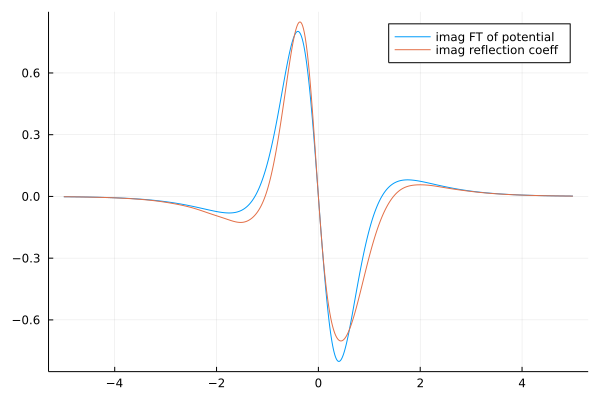

In [33]:
#plot(x,abs.(y1/A),label = "abs y1")
#plot!(x,abs.(y2/A),label = "abs y2")

#lot(x,real(y1/A),label = "real y1")
#plot!(x,real(y2/A),label = "real y2")

plot(x,imag(y1/A),label = "imag FT of potential")
plot!(x,imag(y2/A),label = "imag reflection coeff")

In [7]:
F = FourierTransform(1.0) # negative in fourier exponent

#### THIS IS THE KERNEL FUNCTION ####
ρ = 1/(2*pi)*(F*Fun(zai(x -> ρ_notfun(x/2,out)),OscLaurent(0.0,1.0),200)) |> AKNS.SumFun |> remove_deltas!;
ρconj = x -> conj(ρ(x))

#17 (generic function with 1 method)

## From the notes of Li-Cheng, the first two terms of the expansion are

$$q(x)=\varrho(x)+\iint_{\mathbb{R}_+^2}\mathrm{d}s\mathrm{d}s' \varrho(x+s)\tilde{\varrho}(-s-s'-x)
\varrho(x+s') $$

One would also expect that $\tilde{\varrho}(x)=\varrho(x)^*$ since we chose $r(x)=q(x)^*$

In [27]:
quad = gausslegendre(60)

## I checked that the Gauss Legendre weigts given here are the same as the one in Mathematica 

function potential_fredholm(x)
    M = abs(x) + 30
    xs = M*(quad[1] .+ 1)/2
    ω = sqrt.(quad[2]*M/2)
    W = Diagonal(ω)
    f = (X,Y) -> ρ(x+X+Y+5e-16)
    Ax = W*f.(xs,xs')*W

    f = (X,Y) -> ρconj(x+X+Y+5e-16)
    Bx = W*f.(xs,xs')*W

    Avec = W*map(z -> ρ(x+z+5e-16),xs)
    ρ(x) + Avec'*((I - Bx*Ax)\(Bx*Avec))
end

function potential_fredholm_firstOrder(x)
    M = abs(x) + 40
    xs = M*(quad[1] .+ 1)/2
    ω = sqrt.(quad[2]*M/2)
    W = Diagonal(ω)
    f = (X,Y) -> ρ(x+X+Y+5e-16)
    Ax = W*f.(xs,xs')*W

    f = (X,Y) -> ρconj(-x-X-Y-5e-16)
    Bx = W*f.(xs,xs')*W

    Avec = W*map(z -> ρ(x+z+5e-16),xs)
    ρ(x) + Avec'*Bx*Avec
end

potential_fredholm_firstOrder (generic function with 1 method)

In [9]:
potential_fredholm(1)

-0.009325487438861357 - 0.12935101607691046im

In [21]:
print(q(1))
print("\n")
print(ρ(1))
print("\n")
print(potential_fredholm_firstOrder(1))

-0.011230440561060394 - 0.12912339396625824im
-0.010467061450814994 - 0.12675744188661492im
-0.011639657153756778 - 0.12394184563889474im

In [28]:
x = -10:0.011:10
# Potential on grid
y1 = map(x -> q(x),x);
# FT of computed reflection coefficient
y2 = map(ρ,x);
# FT of computed reflection coefficient
y3 = map(potential_fredholm_firstOrder,x);

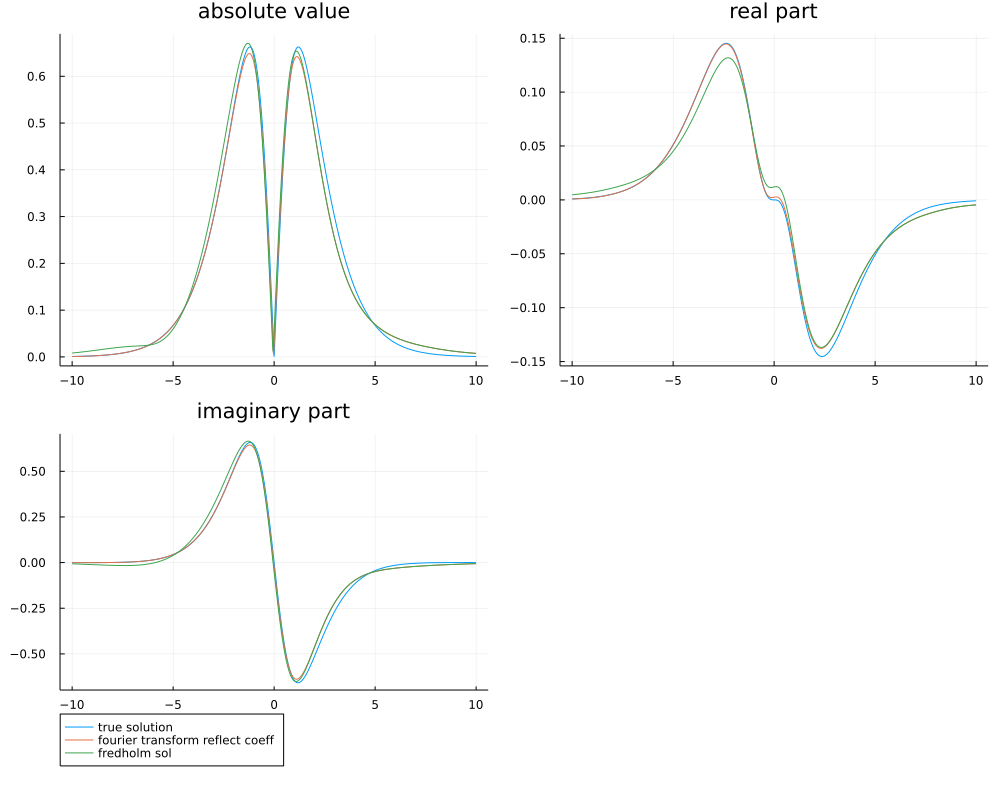

In [29]:

## Compare potential with FT of reflection
plot(x,abs.(y1/A), label="true solution", title="absolute value")
absplot = plot!(x,abs.(y2/A), label="fourier transform reflect coeff", legend = false)
plot!(x,abs.(y3/A), label = "fredholm sol")

plot(x,real(y1/A), label="true solution", title="real part");
realplot = plot!(x,real(y2/A), label="fourier transform reflect coeff", legend = false);
plot!(x,real(y3/A),  label = "fredholm sol")

plot(x,imag(y1/A), label="true solution", title="imaginary part");
imagplot = plot!(x,imag(y2/A), label="fourier transform reflect coeff", legend = :outerbottom);
plot!(x,imag(y3/A), label = "fredholm sol")


plot(absplot, realplot, imagplot, size=(1000,800))


In [30]:
x = -10:0.011:10;
# Potential on grid
y1 = map(x -> r(x),x);
# FT of computed reflection coefficient
y2 = map(ρconj,x);
# FT of computed reflection coefficient
#y3 = map(potential_fredholm_firstOrder,x)

1819-element Vector{ComplexF64}:
 0.00017800448692053956 + 2.6116099607509024e-5im
 0.00017913462875930044 + 2.6501112125048462e-5im
 0.00018028085964730717 + 2.6891242774615638e-5im
 0.00018144360842588817 + 2.728632863934518e-5im
 0.00018262330810635125 + 2.7686201881292027e-5im
  0.0001838203957757616 + 2.8090689755231037e-5im
 0.00018503531250004527 + 2.849961462473507e-5im
  0.0001862685032244424 + 2.8912793980533606e-5im
 0.00018752041667135141 + 2.9330040461152924e-5im
 0.00018879150523559485 + 2.9751161875835876e-5im
                        ⋮
 -0.0009483241925704215 + 0.0012448141894553222im
 -0.0009446304192650583 + 0.0012385091120863958im
 -0.0009409542441502941 + 0.001232238580345445im
 -0.0009372952724965066 + 0.0012260025191298827im
 -0.0009336531139715049 + 0.0012198008511921665im
 -0.0009300273827496844 + 0.0012136334971483487im
 -0.0009264176976176697 + 0.0012075003754873817im
 -0.0009228236820764396 + 0.0012014014025811962im
 -0.0009192449644398937 + 0.0011953364926955

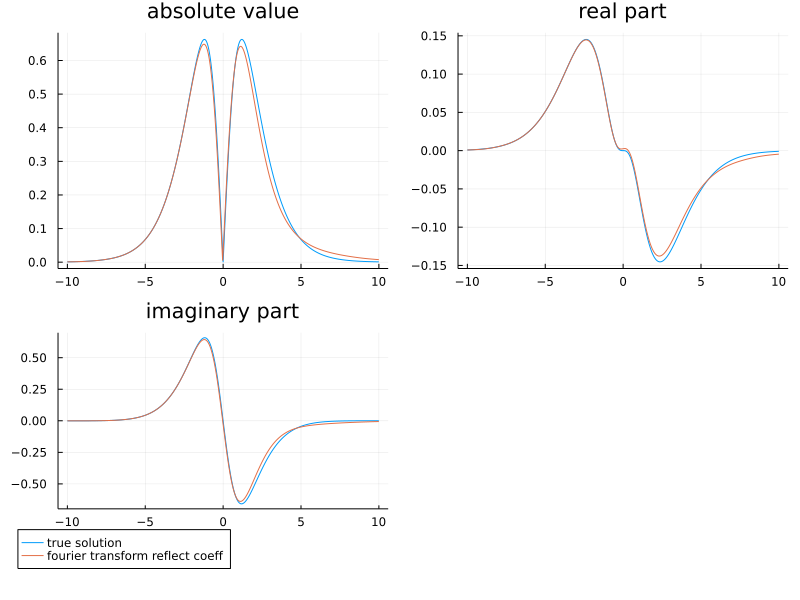

In [14]:

## Compare potential with FT of reflection
plot(x,abs.(y1/A), label="true solution", title="absolute value")
absplot = plot!(x,abs.(y2/A), label="fourier transform reflect coeff", legend = false)
#plot!(x,abs.(y3/A), label = "fredholm sol")

plot(x,real(y1/A), label="true solution", title="real part");
realplot = plot!(x,real(y2/A), label="fourier transform reflect coeff", legend = false);
#plot!(x,real(y3/A),  label = "fredholm sol")

plot(x,imag(y1/A), label="true solution", title="imaginary part");
imagplot = plot!(x,imag(y2/A), label="fourier transform reflect coeff", legend = :outerbottom);
#plot!(x,imag(y3/A), label = "fredholm sol")


plot(absplot, realplot, imagplot, size=(800,600))
